<a href="https://colab.research.google.com/github/sahar-mariam/kannada-sentiment-analysis/blob/main/m_BERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets scikit-learn matplotlib seaborn # installing dependencies


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [8]:
# importing necessary libraries
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# loading the dataset
file_path = "/content/balanced_dataset.csv"  # Upload your file to Colab
df = pd.read_csv(file_path)

# displaying dataset info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3885 entries, 0 to 3884
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   textID             3885 non-null   object 
 1   text               3885 non-null   object 
 2   sentiment          3885 non-null   object 
 3   Time of Tweet      3885 non-null   object 
 4   Age of User        3885 non-null   object 
 5   Country            3885 non-null   object 
 6   Population -2020   3885 non-null   float64
 7   Land Area (Km²)    3885 non-null   float64
 8   Density (P/Km²)    3885 non-null   float64
 9   sentiment_numeric  3885 non-null   int64  
dtypes: float64(3), int64(1), object(6)
memory usage: 303.6+ KB
None
       textID                                               text sentiment  \
0  c5ec3e9e37  ನಾನಿನ್ನೂ ಅಲ್ಲ. ನಾನು RR ಮತ್ತು ನನ್ನ ಬಿಯರ್ ಅನ್ನು ...     ತಟಸ್ಥ   
1  2a5bb8d827  ಬಿ-ಡೇ ಶುಭಾಶಯಗಳು! ಭೂಮಿಯ ಈ ಭಾಗದಲ್ಲಿ ಈಗಷ್ಟೇ ಎಚ್ಚರ...   ಧನಾತ್ಮಕ   
2  02b43cd23c 

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3236 (\N{KANNADA LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Kannada natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3231 (\N{KANNADA LETTER TTA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3256 (\N{KANNADA LETTER SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3277 (\N{KANNADA SIGN VIRAMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylab

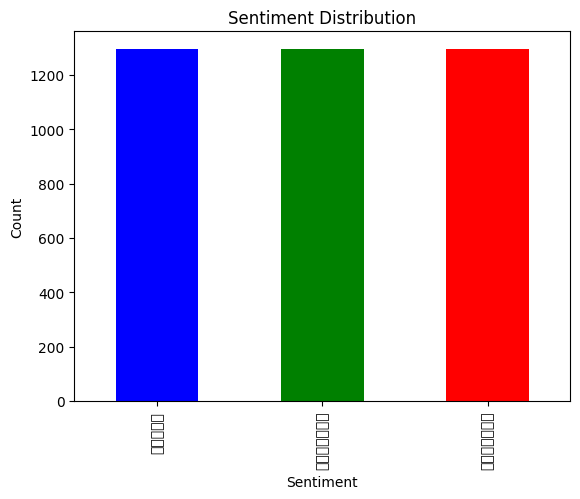

In [6]:
# Exploratory Data Analysis (EDA)
# visualizing sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()



In [9]:
# Data Preparation
# Preprocess the data for m-BERT
df['label'] = df['sentiment_numeric']  # Use numerical labels
df = df[['text', 'label']]  # Select relevant columns

# Split the data into train and test sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/3108 [00:00<?, ? examples/s]

Map:   0%|          | 0/777 [00:00<?, ? examples/s]

In [10]:
# Define the model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {
        "accuracy": (p.predictions.argmax(axis=1) == p.label_ids).mean()
    }
)

# Train the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-10-63cf3ded3d22>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to 

Epoch,Training Loss,Validation Loss,Accuracy
1,1.129200,0.998451,0.580438
2,0.826700,0.798011,0.657658


Epoch,Training Loss,Validation Loss,Accuracy
1,1.129200,0.998451,0.580438
2,0.826700,0.798011,0.657658
3,0.774700,0.798524,0.643501


TrainOutput(global_step=585, training_loss=0.9267474190801637, metrics={'train_runtime': 9609.854, 'train_samples_per_second': 0.97, 'train_steps_per_second': 0.061, 'total_flos': 613317376723968.0, 'train_loss': 0.9267474190801637, 'epoch': 3.0})

In [11]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.7980112433433533, 'eval_accuracy': 0.6576576576576577, 'eval_runtime': 244.1175, 'eval_samples_per_second': 3.183, 'eval_steps_per_second': 0.053, 'epoch': 3.0}


In [ ]:
# Classification Report
val_predictions = trainer.predict(val_dataset)
val_preds = val_predictions.predictions.argmax(axis=-1)
print(classification_report(val_labels, val_preds, target_names=['Neutral', 'Positive', 'Negative']))

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neutral', 'Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to predict sentiment for user input
def predict_sentiment(user_input, model, tokenizer):
    # Tokenize the user input
    inputs = tokenizer(user_input, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Move input tensors to the correct device (GPU or CPU)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()

    # Sentiment mapping
    sentiment_map = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
    predicted_sentiment = sentiment_map[prediction]

    return predicted_sentiment

# Load the model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3).to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Example: Taking user input and predicting sentiment
user_input = input("Enter a sentence in Kannada: ")

# Predict sentiment
predicted_sentiment = predict_sentiment(user_input, model, tokenizer)
print(f"Predicted Sentiment: {predicted_sentiment}")

# To evaluate the prediction accuracy, you can also compare it with the true sentiment (for example, you can manually input the true sentiment for accuracy evaluation)
true_sentiment = int(input("Enter the true sentiment label (0: Neutral, 1: Positive, 2: Negative): "))
accuracy = accuracy_score([true_sentiment], [prediction])
print(f"Accuracy Score: {accuracy}")
